In [30]:
import yaml
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import pandas as pd
import numpy as np

In [31]:
import os,sys
root_path = os.path.dirname(os.path.dirname(os.path.abspath('run.py')))
sys.path.append(root_path)
from cfg import cfg
from numerapi.numerapi import NumerAPI
import models
from data_utils import data_files
from data_utils import get_data_era_balanced,data_files,get_data, write_to_csv


In [32]:
kwargs = cfg['api']

In [33]:
import os,sys
root_path = os.path.dirname(os.path.dirname(os.path.abspath('run.py')))
sys.path.append(root_path)

from cfg import cfg
from numerapi.numerapi import NumerAPI
import models
from data_utils import get_data_era_balanced,data_files,get_data, write_to_csv
import imp
from models import opt

model_list = [
    ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
    ('aec',models.aec.AecModel,dict(istrain=False)),
    ('xg',models.xg.XgModel,dict(istrain=False)),
    ('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
    ('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)),
    ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
    ('simplekfold',models.simplekfold.SimpleKfold,dict(istrain=False)),
    ('disentangle_kfold',models.disentangle_kfold.DisentangleKfoldModel,dict(istrain=False)),
]

In [34]:
X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])
X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(314837, 50) (314837,) (78776, 50) (78776,)


In [35]:
import imp
imp.reload(models)
model_list = [
     ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
    ('aec',models.aec.AecModel,dict(istrain=False)),
     #('xg',models.xg.XgModel,dict(istrain=False)),
     #('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
     #('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)), # depends on model from AecAdvModel
#    ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
#     ('disentangle',models.disentangle.DisentangleModel,dict(istrain=False)),
     ('disentangle_kfold',models.disentangle_kfold.DisentangleKfoldModel,dict(istrain=False)),
#     ('disentanglegan',models.disentanglegan.DisentangleGanModel,dict(istrain=False)),
     #('idg',models.icadisengan.IcaDisentangleGanModel,dict(istrain=False)),
     #('mdg',models.moddisengan.DisentangleModel,dict(istrain=True)),
#    ('tsnesimple',models.tsne_simple.TsneSimple,dict(istrain=False)),
#    ('tsnesimplekfold',models.tsne_simplekfold.TsneSimpleKfold,dict(istrain=False)),
#    ('simple',models.simple.Simple,dict(istrain=False)),
    ('simplekfold',models.simplekfold.SimpleKfold,dict(istrain=False)),
]

In [36]:
val_inds = np.array(np.where(_datatypes=='validation')).squeeze()

In [37]:
val_inds.shape

(46362,)

In [38]:

def to_int(e):
    try:
        return int(e.strip('era'))
    except:
        return float('nan')
ll_list = [{},{}]
raw = {}


for n,p in enumerate(['trainpath','testpath']):
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    index_dict={}
    X_train_tr,y_train_tr,X_val_tr,y_val_tr = get_data_era_balanced(
        data_files[-1][p],index_dict=index_dict)
    X__ = X_val_tr
    y__ = y_val_tr
    
    eras__ = eras__[index_dict['validation']]
    
    val_eras = sorted([x for x in np.unique(eras__) if x not in ['eraX']])
    raw[p]={'y_true':y__,'m':{},'eras':eras__,'val_eras':val_eras}
    ll={}
    for name,clsf,params in model_list:
        inst = clsf()
        inst.load()
        y_pred,_ = inst.predict(X__)
        raw[p]['m'][name]={'y_pred':y_pred}
        ll[name]=[]
        for era in val_eras:
            inds = np.array(np.where(eras__==era)).squeeze()            
            l = opt.log_loss_func([1.],[y_pred[inds]],y__[inds])
            ll[name].append({'eras':to_int(era),'log_loss':l,'stds':np.nanstd(y_pred[inds].squeeze()-y__[inds])})
        ll[name] = pd.DataFrame(ll[name])
    ll_list[n].update(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))
# https://github.com/numerai/submission-criteria/blob/daac1970a984cd4392c720771d3c5c4bcb9de1d4/submission_criteria/database_manager.py#L71 

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(314837, 50) (314837,) (78776, 50) (78776,)


/home/yoyoteng/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


(78776, 1)
[  4.85957773e-01   1.11022302e-16   9.35383216e-03   7.97761814e-02
   4.24912213e-01] (5, 78776) (78776,)
0
1
2
3
4
trainpath aec cons:0.5833 logloss:0.6930
trainpath aecgan cons:0.5000 logloss:0.6932
trainpath disentangle_kfold cons:0.6917 logloss:0.6929
trainpath simplekfold cons:0.7917 logloss:0.6916
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(37084, 50) (37084,) (9278, 50) (9278,)
(9278, 1)
[  4.85957773e-01   1.11022302e-16   9.35383216e-03   7.97761814e-02
   4.24912213e-01] (5, 9278) (9278,)
0
1
2
3
4
testpath aec cons:0.6667 logloss:0.6925
testpath aecgan cons:0.4167 logloss:0.6932
testpath disentangle_kfold cons:0.9167 logloss:0.6928
testpath simplekfold cons:1.0000 logloss:0.6905


In [39]:


print('ok')
name = 'opt'
for n,p in enumerate(['trainpath','testpath']):
    y_true = raw[p]['y_true']
    pred_list = []
    for k,v in raw[p]['m'].items():
        pred_list.append(v['y_pred'].squeeze())
    
    if p =='trainpath':
        w = opt.opt_weights(pred_list,y_true)
    
    pred_list = np.array(pred_list)
    # calculate pred
    y_pred = np.dot(w,pred_list)
    print(y_pred.shape)
    #raw[p]={'y_true':y__,'m':{},'eras':eras__,'val_eras':val_eras}
    val_eras = raw[p]['val_eras']
    eras__ = raw[p]['eras']
    y__ = raw[p]['y_true']
    print(y__.shape)
    ll={name:[]}
    for era in val_eras:
        inds = np.array(np.where(eras__==era)).squeeze()
        l = opt.log_loss_func([1.],[y_pred[inds]],y__[inds])
        ll[name].append({'eras':to_int(era),'log_loss':l,'stds':np.nanstd(y_pred[inds].squeeze()-y__[inds])})
    ll[name] = pd.DataFrame(ll[name])
    
    ll_list[n].update(ll)


ok
!! (4, 78776) (78776,)
Ensemble Score: 0.24977956260350176
Best Weights: [ 0.40879004  0.13417276  0.06699279  0.3900444 ]
Ensemble Score: 0.24965193649645015
Best Weights: [  5.06736588e-01   2.59741728e-01   2.33521684e-01   5.55111512e-17]
Ensemble Score: 0.24950386937008795
Best Weights: [ 0.2990049   0.09004175  0.42845992  0.18249343]
Ensemble Score: 0.2497389017912885
Best Weights: [ 0.5383159   0.09986644  0.12500698  0.23681067]
Ensemble Score: 0.24936223916704095
Best Weights: [ 0.          0.02769801  0.68956579  0.2827362 ]
Ensemble Score: 0.24954761552101315
Best Weights: [ 0.01544684  0.48154215  0.39382517  0.10918583]
Ensemble Score: 0.2496169729034299
Best Weights: [ 0.05018656  0.19238023  0.26622451  0.4912087 ]
Ensemble Score: 0.24948645311734313
Best Weights: [  4.44089210e-16   1.99508127e-01   4.53746778e-01   3.46745095e-01]
Ensemble Score: 0.24956471880302122
Best Weights: [  2.40073457e-01   2.77555756e-17   3.44124165e-01   4.15802378e-01]
Ensemble Score: 

In [40]:
print('\n'.join(['{} {:1.4f}'.format(m[0],w0) for m,w0 in zip(model_list,w)]))

aecgan 0.0000
aec 0.0277
disentangle_kfold 0.6896
simplekfold 0.2827


aec
0.49955 0.5833 70 120
0.49925 0.6667 8 12
--
aecgan
0.49963 0.5000 60 120
0.49963 0.4167 5 12
--
disentangle_kfold
0.49951 0.6917 83 120
0.49939 0.9167 11 12
--
opt
0.49897 0.8000 96 120
0.49852 1.0000 12 12
--
simplekfold
0.49885 0.7917 95 120
0.49825 1.0000 12 12
--


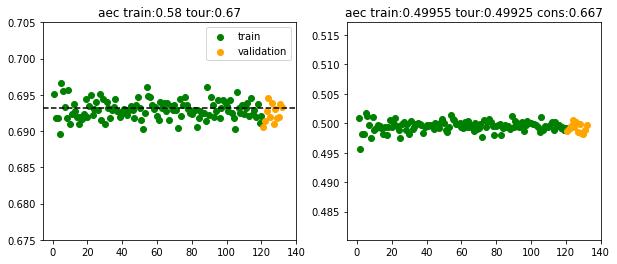

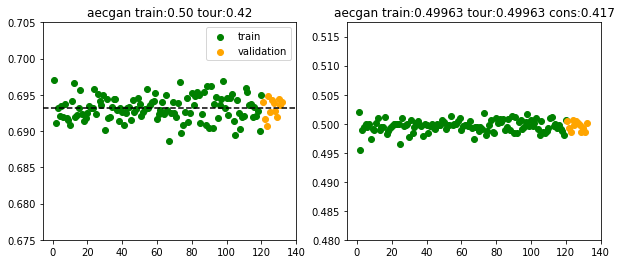

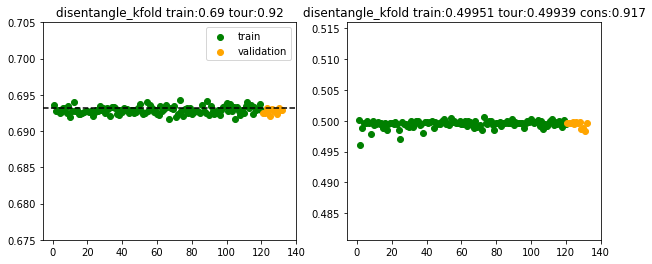

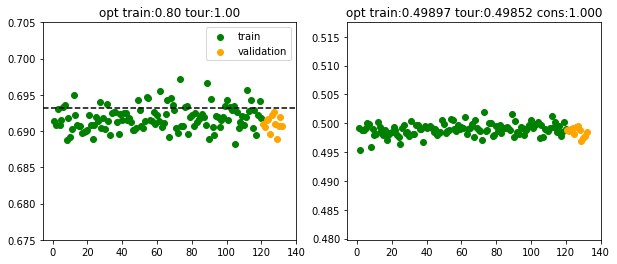

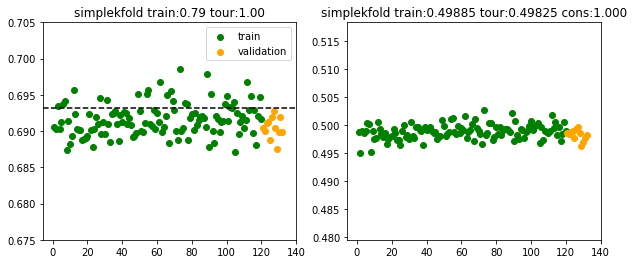

In [41]:
m_list = ['disentangle']#,'aecgan'
m_list = list(sorted(ll_list[0].keys()))

for n,mn in enumerate(m_list):
    tr_dn=np.sum(ll_list[0][mn].log_loss < -np.log(0.5))
    tr_nu=ll_list[0][mn].log_loss.shape[0]
    tr_cons=tr_dn/float(tr_nu)
    tr_std=ll_list[0][mn].stds.mean()
    print(mn)
    print('{:1.5f} {:1.4f} {} {}'.format(tr_std,tr_cons,tr_dn,tr_nu))
    tor_dn=np.sum(ll_list[1][mn].log_loss < -np.log(0.5))
    tor_nu=ll_list[1][mn].log_loss.shape[0]
    tor_std=ll_list[1][mn].stds.mean()
    tor_cons=tor_dn/float(tor_nu)
    print('{:1.5f} {:1.4f} {} {}'.format(tor_std,tor_cons,tor_dn,tor_nu))
    print('--')
    plt.figure(n,figsize=(10,4))
    plt.subplot(121)
    plt.title('{} train:{:1.2f} tour:{:1.2f}'.format(mn,tr_cons,tor_cons))
    plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
    plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
    plt.ylim(0.675,0.705)
    plt.legend()
    plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
    plt.subplot(122)
    plt.title('{} train:{:1.5f} tour:{:1.5f} cons:{:1.3f}'.format(mn,tr_std,tor_std,tor_cons))
    plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].stds,label='train',color='green')
    plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].stds,label='validation',color='orange')


disentangle_kfold
0.49951 0.6917 83 120
0.49939 0.9167 11 12
--


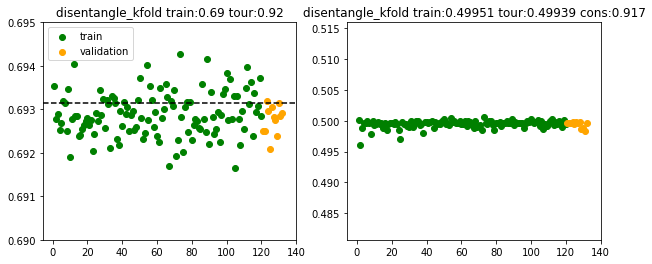

In [29]:
m_list = ['disentangle_kfold']
for n,mn in enumerate(m_list):
    tr_dn=np.sum(ll_list[0][mn].log_loss < -np.log(0.5))
    tr_nu=ll_list[0][mn].log_loss.shape[0]
    tr_cons=tr_dn/float(tr_nu)
    tr_std=ll_list[0][mn].stds.mean()
    print(mn)
    print('{:1.5f} {:1.4f} {} {}'.format(tr_std,tr_cons,tr_dn,tr_nu))
    tor_dn=np.sum(ll_list[1][mn].log_loss < -np.log(0.5))
    tor_nu=ll_list[1][mn].log_loss.shape[0]
    tor_std=ll_list[1][mn].stds.mean()
    tor_cons=tor_dn/float(tor_nu)
    print('{:1.5f} {:1.4f} {} {}'.format(tor_std,tor_cons,tor_dn,tor_nu))
    print('--')
    plt.figure(n,figsize=(10,4))
    plt.subplot(121)
    plt.title('{} train:{:1.2f} tour:{:1.2f}'.format(mn,tr_cons,tor_cons))
    plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
    plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
    plt.ylim(0.690,0.695)
    plt.legend()
    plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
    plt.subplot(122)
    plt.title('{} train:{:1.5f} tour:{:1.5f} cons:{:1.3f}'.format(mn,tr_std,tor_std,tor_cons))
    plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].stds,label='train',color='green')
    plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].stds,label='validation',color='orange')


In [ ]:
aec=models.aec.AecModel()
aec.load()
adv=models.aec_gan.AecAdvModel()
adv.load()
adx=models.aec_gan_xg.AecGanXgModel()
adx.load()

In [ ]:
for x in [X_train,X_val,X_test]:
    aecdX = aec.decoder.predict(x)
    advdX = adv.decoder.predict(x)
    adxdX = adx.aa_inst.decoder.predict(x)
    print('---------')
    print('aec',metrics.mean_squared_error(aecdX,x))
    print('adv',metrics.mean_squared_error(advdX,x))
    print('adx',metrics.mean_squared_error(adxdX,x))

In [ ]:
mn = 'aecganxg'
plt.figure(0)
plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
plt.figure(1)
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

#X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])
#X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

# Score on the training set was:0.6049871246781169
# exported_pipeline = make_pipeline(
#     FastICA(tol=0.35000000000000003),
#     StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=14, n_estimators=100)),
#     ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=17, min_samples_split=13, n_estimators=100)
# )
args = [
    FastICA(tol=0.35000000000000003),
    StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=7, n_estimators=100)),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=, min_samples_split=6, n_estimators=80),

]
exported_pipeline = make_pipeline(
    *args,
    memory=memory
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)


import pickle
with open('mymodel','wb') as f:
    pickle.dump(model,f)

In [ ]:
for p in ['trainpath','testpath']:
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    results = exported_pipeline.predict_proba(X__)
    val_eras = [x for x in np.unique(eras__) if x not in ['eraX']]
    ll = {}
    name = 'tpot'
    ll[name]=[]
    for era in val_eras:
        inds = np.array(np.where(eras__==era)).squeeze()
        l = opt.log_loss_func([1.],[results[inds]],y__[inds])
        ll[name].append({'eras':to_int(era),'log_loss':l})
    ll[name] = pd.DataFrame(ll[name])
    ll_list.append(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))


In [ ]:
opt_weights = opt.opt_weights(y_pred_list,y_test[val_inds])

In [ ]:
opt_pred = opt.opt_pred(y_pred_list,opt_weights)
print(len(y_pred_list),opt_weights.shape,opt_pred.shape)
print('final logloss',name,opt.log_loss_func([1.0],[opt_pred],y_test[val_inds]))

In [ ]:
print(['{:.8f}'.format(x) for x in opt_weights])
print(np.sum(opt_weights))